# **Modelos para imágenes**

Entrenar y comparar **ResNet18, ResNet34** sobre los volúmenes `.npy` de resonancia magnética.

**Características principales:**
- Volúmenes: `(160,192,192)`
- Se extraen 10/20 cortes axiales centrales
- Entrada redimensionada a `224×224` (para ResNet)
- Pérdida: `BCEWithLogitsLoss` con `pos_weight` (para balanceo)
- Evaluación: **Balanced Accuracy (BAC)**
- Modelos con **Batch Normalization**.


In [1]:
import os, glob, math, random, time, json, torch_directml
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet18, resnet34, resnet50
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights


from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, confusion_matrix

print('PyTorch version', torch.__version__)

PyTorch version 2.4.1+cpu


In [2]:
# Configuration 
DATA_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\datos\procesadas")
LABELS_CSV = r"C:\Users\Hp\MACHINE\MRI\notebooks\Data\atributos.csv"
OUTPUT_DIR = "models_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# Helper functions: intensity normalization, slice extraction
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def contrast_normalize_volume(vol, pmin=2, pmax=98):     
    vmin = np.percentile(vol, pmin)    
    vmax = np.percentile(vol, pmax)    
    vol = np.clip(vol, vmin, vmax)    
    vol = (vol - vmin) / (vmax - vmin + 1e-9)    
    return vol.astype(np.float32)

def get_central_slices(vol, n_slices=10):  
    """ Extract n central axial slices from a volume shaped.   """
    D = vol.shape[0]    
    center = D // 2    
    half = n_slices // 2   
    start = max(0, center - half)    
    end = min(D, start + n_slices)
    slices = vol[start:end]
    if slices.shape[0] < n_slices:  # padding si faltan
        pad_before = (n_slices - slices.shape[0]) // 2
        pad_after = n_slices - slices.shape[0] - pad_before
        slices = np.concatenate([
            np.repeat(slices[[0]], pad_before, axis=0),
            slices,
            np.repeat(slices[[-1]], pad_after, axis=0)
        ], axis=0)
    return slices

In [4]:
# Dataset: loads one volume per item and returns tensor of shape (n_slices, C, H, W)
class MRIVolumeDataset(Dataset):
    def __init__(self, records, n_slices=10, target_size=(224,224), transform=None, skull_strip=False):
        self.records = records        
        self.n_slices = n_slices        
        self.target_size = target_size        
        self.transform = transform        
        self.skull_strip = skull_strip    
        
    def __len__(self):        
        return len(self.records)
        
    def __getitem__(self, idx):
        rec = self.records[idx]
        vol = np.load(rec['path'])  # Volumen (160,192,192)

        vol = contrast_normalize_volume(vol)
        slices = get_central_slices(vol, self.n_slices)

        imgs = []
        for s in slices:
            img = Image.fromarray((s * 255).astype(np.uint8))
            img = img.resize(self.target_size)
            img = img.convert("RGB")

            if self.transform:
                img = self.transform(img)
            else:
                img = T.Compose([
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])(img)
            imgs.append(img)

        imgs = torch.stack(imgs, dim=0)  # (n_slices, C, H, W)
        label = torch.tensor(rec['label'], dtype=torch.float32)
        
        return imgs, label, rec['sujeto_id']  

In [5]:
# [Clase] Modelo RestNet
class ResNetSliceClassifier(nn.Module):
    def __init__(self, backbone_name='resnet18', pretrained=False, n_slices=10, dropout=0.4):
        super().__init__()
        self.n_slices = n_slices

        if backbone_name == 'resnet18':
            base = resnet18(weights=None if not pretrained else ResNet18_Weights.DEFAULT)
            feat_dim = base.fc.in_features

        elif backbone_name == 'resnet34':
            base = resnet34(weights=None if not pretrained else ResNet34_Weights.DEFAULT)
            feat_dim = base.fc.in_features
        else:
            raise ValueError(f"Modelo no soportado: {backbone_name}")
        # Secuencia de la red
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(feat_dim, 1)

    # Paso forward
    def forward(self, x):
        B, S, C, H, W = x.shape
        x = x.view(B*S, C, H, W)
        feats = self.backbone(x)
        feats = self.global_pool(feats).view(B, S, -1)
        agg = feats.mean(dim=1)
        out = self.dropout(agg)
        logits = self.classifier(out).squeeze(1)
        return logits


In [6]:
def build_records(data_dir, labels_csv):
    labels_df = pd.read_csv(labels_csv, dtype={'sujeto_id': str})
    labels_df = labels_df.dropna(subset=['is_dementia']) # Excluir imágenes sin datos
    labels_df['sujeto_id'] = labels_df['sujeto_id'].str.strip()
    label_map = dict(zip(labels_df['sujeto_id'], labels_df['is_dementia']))

    records = []
    for p in glob.glob(os.path.join(data_dir, "*.npy")):
        subj = os.path.basename(p)[:10].strip()
        if subj in label_map:
            records.append({"path": p, "sujeto_id": subj, "label": int(label_map[subj])})
    return records

# División estratificada
def group_stratified_split(records, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    df = pd.DataFrame(records)
    subj_lab = df.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))
    subjects = subj_lab.index.to_list()
    y = subj_lab.values

    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    train_idx, rest_idx = next(gss.split(subjects, y, groups=subjects))
    train_subj = [subjects[i] for i in train_idx]
    rest_subj = [subjects[i] for i in rest_idx]

    val_prop = val_size / (val_size + test_size)
    val_subj, test_subj = train_test_split(rest_subj, test_size=1 - val_prop, random_state=seed, stratify=[subj_lab[s] for s in rest_subj])

    def select_by_subject(subj_list):
        return [r for r in records if r["sujeto_id"] in subj_list]

    return select_by_subject(train_subj), select_by_subject(val_subj), select_by_subject(test_subj)


In [7]:
def compute_class_weights(records):
    labels = [r['label'] for r in records]
    cnt0 = sum(l == 0 for l in labels)
    cnt1 = sum(l == 1 for l in labels)
    pos_weight = torch.tensor([cnt0 / (cnt1 + 1e-9)], dtype=torch.float32)
    return pos_weight, cnt0, cnt1


def evaluate_model(model, dataloader, device):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for X, y, _ in dataloader:
            X, y = X.to(device), y.to(device)
            probs = torch.sigmoid(model(X)).cpu().numpy()
            preds.extend((probs >= 0.5).astype(int))
            ys.extend(y.cpu().numpy().astype(int))
    return balanced_accuracy_score(ys, preds)

# Entrenamiento por épocas
def train_one_model(model, train_loader, val_loader, device, pos_weight, lr=1e-4, epochs=10, patience=3):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    
    best_bac = 0
    best_state = None
    patience_counter = 0
    history = {"epoch": [], "train_loss": [], "val_bac": []}
    time_1 = time.time()

    for e in range(epochs):
        epoch_start = time.time()
        # Entrenamiento
        model.train()
        total_loss = 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        val_bac = evaluate_model(model, val_loader, device)

        epoch_time = time.time() - epoch_start
        avg_loss = total_loss / len(train_loader)

        print(f"Epoch {e+1}/{epochs} | Loss {total_loss/len(train_loader):.4f} | Val BAC {val_bac:.4f} | Tiempo {epoch_time/60:.2f} minutos")
        
        # Guardar historia
        history["epoch"].append(e + 1)
        history["train_loss"].append(avg_loss)
        history["val_bac"].append(val_bac)

        # Early stopping
        if val_bac > best_bac:
            best_bac = val_bac
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping activado en epoch {e+1}")
                break

    total_time = time.time() - time_1
    print(f"Entrenamiento completo en {total_time/60:.2f} minutos")
    model.load_state_dict(best_state)
    return model, history


In [8]:
# Graficar rendimiento
def plot_training_history(history, model_name="modelo"):
    plt.figure(figsize=(8, 4))
    plt.plot(history["epoch"], history["train_loss"], label="Train Loss", marker="o")
    plt.plot(history["epoch"], history["val_bac"], label="Val Balanced Accuracy", marker="s")
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.title(f"Evolución del entrenamiento - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Guardar imagen
    filename = f"models_output/history_{model_name}.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Gráfico guardado en: {filename}")

In [9]:
def main(dry_run=True):
    records = build_records(DATA_DIR, LABELS_CSV)
    print(f"Volúmenes encontrados: {len(records)}")
    train_recs, val_recs, test_recs = group_stratified_split(records, seed = SEED)
    pos_weight, c0, c1 = compute_class_weights(train_recs)
    print(f"Clases: 0={c0}, 1={c1}, pos_weight={pos_weight.item():.2f}")
    print(f"Bach {BATCH_SIZE}, slices {N_SLICES}, epocas {EPOCHS}")

    transform = T.Compose([
        T.RandomHorizontalFlip(0.5),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    # Extraer imágenes
    train_ds = MRIVolumeDataset(train_recs, transform=transform)
    val_ds = MRIVolumeDataset(val_recs)
    test_ds = MRIVolumeDataset(test_recs)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    if dry_run:
        X, y, _ = next(iter(train_loader))
        print("Ejemplo:", X.shape, y.shape)
        return

    # Estructura principal
    results = []
    for backbone in ['resnet18','resnet34']:
        print(f"\n=== Entrenando {backbone} ===")
        model = ResNetSliceClassifier(backbone, n_slices=N_SLICES) # type: ignore
        trained, history = train_one_model(model, train_loader, val_loader, DEVICE, pos_weight, lr=LR, epochs=EPOCHS)
        plot_training_history(history, model_name=f"{backbone}_slices{N_SLICES}")
        test_bac = evaluate_model(trained, test_loader, DEVICE)
        results.append((backbone, test_bac))
        print(f"Test BAC ({backbone}): {test_bac:.4f}")

        torch.save(trained.state_dict(), f"{OUTPUT_DIR}/{backbone}_Slices{N_SLICES}_Learning{LR}_model.pth")
        print(f"Modelo guardado: {OUTPUT_DIR}/{backbone}_Slices{N_SLICES}_Learning{LR}_model.pth")

    print("\nResumen:")
    for b, bac in results:
        print(f"{b}: {bac:.4f}")


________________________

A continuación, se evaluarán los modelos variando la cantidad de slices centrales que se toman y el learning rate. Se compara la perdida y el BAC durante cada una de las 20 épocas, con detección después de que el rendimiento no avance en 3 épocas. 

In [10]:
# [config] Hiperparámetros
TARGET_SIZE = (224,224)
BATCH_SIZE = 8
NUM_WORKERS = 4
DEVICE = torch.device("cpu")
SEED = 42
set_seed(SEED)
WEIGHT_DECAY = 1e-5
EPOCHS = 20         # Épocas para entrenar
print('Device ->', DEVICE)

Device -> cpu


________________

In [11]:
# 1. 
N_SLICES = 10
LR = 1e-4
main(dry_run=False)

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 10, epocas 20

=== Entrenando resnet18 ===


KeyboardInterrupt: 

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 10, epocas 20

=== Entrenando resnet18 ===
Epoch 1/20 | Loss 0.5615 | Val BAC 0.2093 | Tiempo 3.22 minutos
Epoch 2/20 | Loss 0.4972 | Val BAC 0.5000 | Tiempo 2.85 minutos
Epoch 3/20 | Loss 0.4392 | Val BAC 0.5116 | Tiempo 3.07 minutos
Epoch 4/20 | Loss 0.4311 | Val BAC 0.1163 | Tiempo 2.97 minutos
Epoch 5/20 | Loss 0.3891 | Val BAC 0.3663 | Tiempo 2.91 minutos
Epoch 6/20 | Loss 0.3365 | Val BAC 0.4215 | Tiempo 2.93 minutos
Early stopping activado en epoch 6
Entrenamiento completo en 17.96 minutos


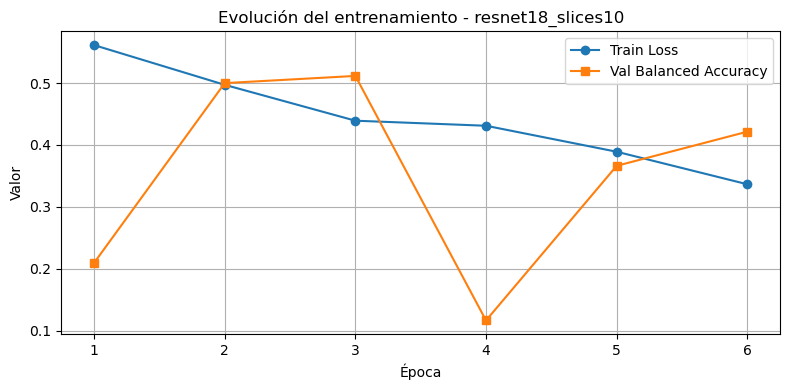

Gráfico guardado en: models_output/history_resnet18_slices10.png
Test BAC (resnet18): 0.0833
Modelo guardado: models_output/resnet18_Slices10_Learning3e-05_model.pth

=== Entrenando resnet34 ===
Epoch 1/20 | Loss 0.5507 | Val BAC 0.5000 | Tiempo 4.42 minutos
Epoch 2/20 | Loss 0.4926 | Val BAC 0.5000 | Tiempo 8.57 minutos
Epoch 3/20 | Loss 0.4875 | Val BAC 0.1512 | Tiempo 4.41 minutos
Epoch 4/20 | Loss 0.3841 | Val BAC 0.5581 | Tiempo 5.63 minutos
Epoch 5/20 | Loss 0.3685 | Val BAC 0.5000 | Tiempo 4.49 minutos
Epoch 6/20 | Loss 0.3324 | Val BAC 0.6279 | Tiempo 4.34 minutos
Epoch 7/20 | Loss 0.2456 | Val BAC 0.6047 | Tiempo 4.30 minutos
Epoch 8/20 | Loss 0.1524 | Val BAC 0.5378 | Tiempo 4.64 minutos
Epoch 9/20 | Loss 0.1160 | Val BAC 0.4070 | Tiempo 4.41 minutos
Early stopping activado en epoch 9
Entrenamiento completo en 45.20 minutos


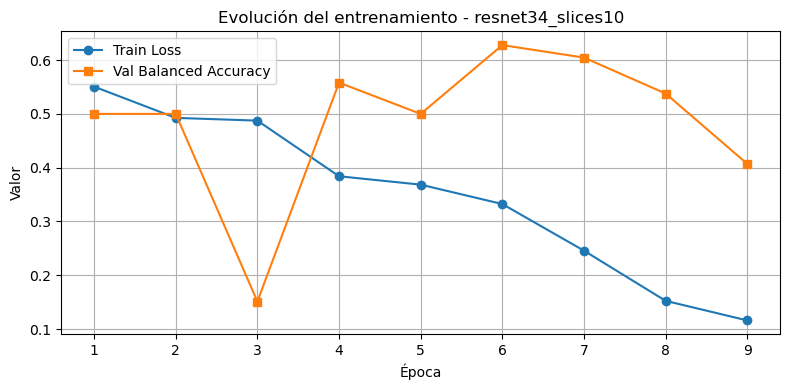

Gráfico guardado en: models_output/history_resnet34_slices10.png
Test BAC (resnet34): 0.4861
Modelo guardado: models_output/resnet34_Slices10_Learning3e-05_model.pth

Resumen:
resnet18: 0.0833
resnet34: 0.4861


In [12]:
#2. 
N_SLICES = 10
LR =  3e-5
main(dry_run=False)

In [ ]:
#3.
N_SLICES = 20
LR = 1e-4
main(dry_run=False)

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 20, epocas 20

=== Entrenando resnet18 ===
Epoch 1/20 | Loss 0.5632 | Val BAC 0.5000 | Tiempo 2.82 minutos
Epoch 2/20 | Loss 0.4215 | Val BAC 0.6047 | Tiempo 2.74 minutos
Epoch 3/20 | Loss 0.3838 | Val BAC 0.5930 | Tiempo 3.00 minutos
Epoch 4/20 | Loss 0.2682 | Val BAC 0.3895 | Tiempo 3.01 minutos
Epoch 5/20 | Loss 0.1956 | Val BAC 0.6512 | Tiempo 3.17 minutos
Epoch 6/20 | Loss 0.1314 | Val BAC 0.5930 | Tiempo 3.34 minutos
Epoch 7/20 | Loss 0.1446 | Val BAC 0.6628 | Tiempo 3.17 minutos
Epoch 8/20 | Loss 0.0920 | Val BAC 0.5000 | Tiempo 2.92 minutos
Epoch 9/20 | Loss 0.1200 | Val BAC 0.6744 | Tiempo 3.11 minutos


In [ ]:
#4.
N_SLICES = 20
LR =  3e-5
main(dry_run=False)

````
Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64

=== Entrenando resnet18 ===
Epoch 1/15 | Loss 0.5104 | Val BAC 0.5000 | Tiempo 3.12 minutos
Epoch 2/15 | Loss 0.4874 | Val BAC 0.5000 | Tiempo 3.14 minutos
Epoch 3/15 | Loss 0.3641 | Val BAC 0.5465 | Tiempo 3.14 minutos
Epoch 4/15 | Loss 0.3012 | Val BAC 0.5814 | Tiempo 2.69 minutos
Epoch 5/15 | Loss 0.3391 | Val BAC 0.4593 | Tiempo 2.75 minutos
Epoch 6/15 | Loss 0.3053 | Val BAC 0.4186 | Tiempo 3.08 minutos
Epoch 7/15 | Loss 0.2211 | Val BAC 0.6512 | Tiempo 3.05 minutos
Epoch 8/15 | Loss 0.1765 | Val BAC 0.6163 | Tiempo 3.12 minutos
Epoch 9/15 | Loss 0.2379 | Val BAC 0.6279 | Tiempo 3.23 minutos
Epoch 10/15 | Loss 0.1450 | Val BAC 0.5145 | Tiempo 2.86 minutos
Early stopping activado en epoch 10
Entrenamiento completo en 30.19 minutos
Test BAC (resnet18): 0.6528

````